# introduction to the vectorizing principle

## part 3: a slightly more complex example

#### load the data:

In [1]:
import pandas as pd
data_df = pd.read_csv('data/taxi_data/train.csv.gz')
len(data_df)

1458644

#### define (vectorized) functions for computing features:

In [2]:
import numpy as np
def feature_trip_distance(df: pd.DataFrame) -> pd.DataFrame:
    start_lat = np.radians(df["pickup_latitude"])
    start_lng = np.radians(df["pickup_longitude"])
    dest_lat = np.radians(df["dropoff_latitude"])
    dest_lng = np.radians(df["dropoff_longitude"])

    d = (
        np.sin(dest_lat / 2 - start_lat / 2) ** 2
        + np.cos(start_lat)
        * np.cos(dest_lat)
        * np.sin(dest_lng / 2 - start_lng / 2) ** 2
    )

    return pd.DataFrame(
        dict(
            # 6,371 km is the earth radius
            haversine_distance = 2 * 6371 * np.arcsin(np.sqrt(d))
        )
    )

def feature_split_pickup_datetime(df: pd.DataFrame) -> pd.DataFrame:
    tpep_pickup_datetime = pd.to_datetime(df["pickup_datetime"])

    return pd.DataFrame(
        {
            "pickup_dayofweek": tpep_pickup_datetime.dt.dayofweek,
            "pickup_hour": tpep_pickup_datetime.dt.hour,
            "pickup_minute": tpep_pickup_datetime.dt.minute,
        }
    )

def get_feature_df(df: pd.DataFrame, target_col="trip_duration") -> pd.DataFrame:
    return pd.concat(
        [
            df[[col for col in df.columns if col != target_col and df[col].dtype in (int, float, bool)]],
            feature_trip_distance(df),
            feature_split_pickup_datetime(df),
        ],
        axis="columns",
    ), df[target_col]


#### split the data into train and test sets (assuming row based features, only!):

In [3]:
from sklearn.model_selection import train_test_split
features_df, target_series = get_feature_df(data_df)
(
    features_train,
    features_test,
    target_train,
    target_test,
) = train_test_split(features_df, target_series, test_size=0.1)

#### train a simple model:

In [4]:
import lightgbm
model = lightgbm.LGBMRegressor(objective="regression_l1")
model.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 1312779, number of used features: 10
[LightGBM] [Info] Start training from score 663.000000


LGBMRegressor(objective='regression_l1')

#### evaluate the model:

0.030918167335125646
3283.5591808924655


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

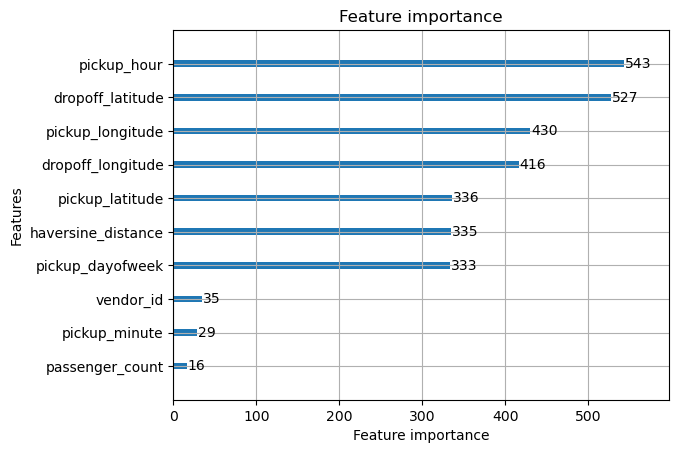

In [5]:
from sklearn.metrics import mean_squared_error
import math
predicted = model.predict(features_test)
print(model.score(features_test, target_test))
print(math.sqrt(mean_squared_error(target_test, predicted)))
lightgbm.plot_importance(model)

#### Exercises:
1) Create a rushhour feature (0 if pickup_hour is between 10 and 16, 1 otherwise) and add it to the feature dataframe.

In [6]:
df = pd.concat([data_df, feature_split_pickup_datetime(data_df)], axis="columns")
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_dayofweek,pickup_hour,pickup_minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,0,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,11,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,19,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,13,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,4,13,31
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6,7,35
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,4,6,57
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,1,15,56


Next: [vectorization04.ipynb](vectorization04.ipynb): defining a data pipeline